#  PROJET D'ANALYSE DE CHURN CLIENT
# Stratégie de Rétention et Prévention de l'Attrition


# 1. IMPORTATION ET EXPLORATION DES DONNÉES


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration de l'affichage
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Chargement des données
df = pd.read_csv('/kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv')

# Aperçu initial
print(" APERÇU DU DATASET")
print(f"Dimensions: {df.shape[0]} lignes × {df.shape[1]} colonnes")
print(f"Taux de churn global: {df['Attrition'].value_counts(normalize=True)['Yes']*100:.1f}%")

# Inspection des données
print("\n INFORMATIONS SUR LES DONNÉES")
print(df.info())
print("\n STATISTIQUES DESCRIBTIVES")
print(df.describe())

# Vérification des valeurs manquantes
print("\n VALEURS MANQUANTES")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])

 APERÇU DU DATASET
Dimensions: 1470 lignes × 35 colonnes
Taux de churn global: 16.1%

 INFORMATIONS SUR LES DONNÉES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate      

# 2. ANALYSE EXPLORATOIRE (EDA) COMPLÈTE

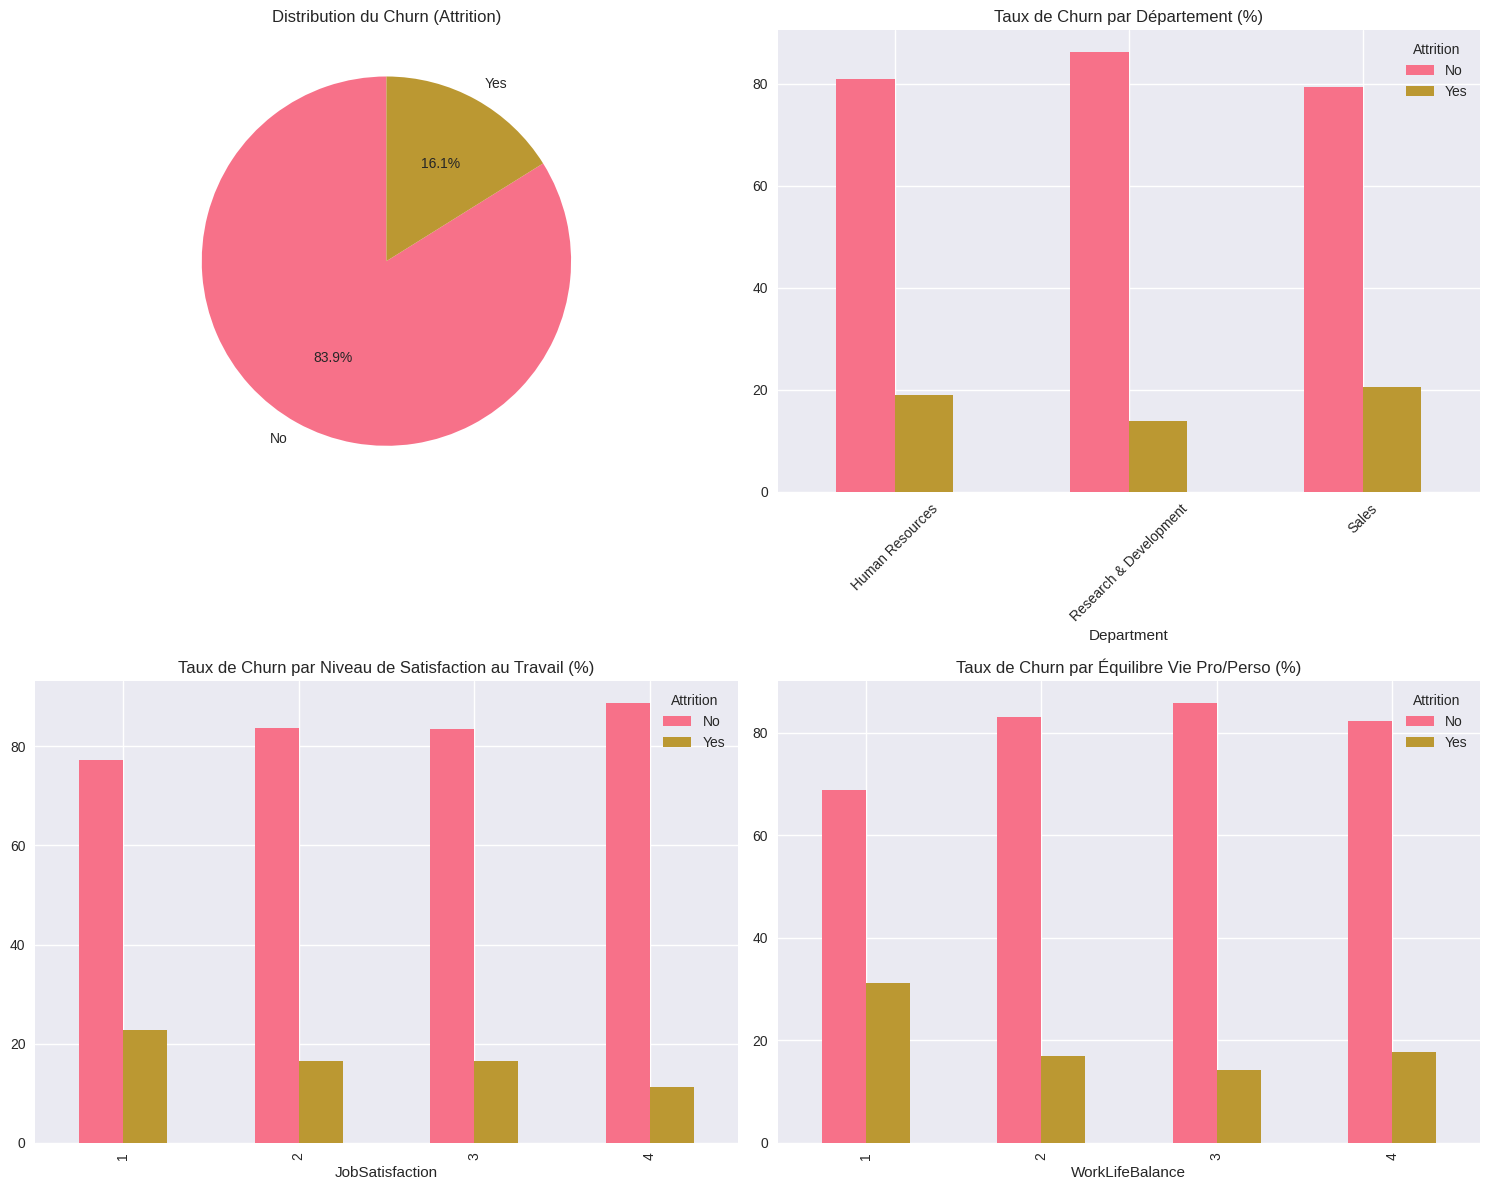

In [4]:
# Configuration des graphiques
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribution du churn
attrition_counts = df['Attrition'].value_counts()
axes[0,0].pie(attrition_counts.values, labels=attrition_counts.index, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Distribution du Churn (Attrition)')

# 2. Churn par département
dept_churn = pd.crosstab(df['Department'], df['Attrition'], normalize='index') * 100
dept_churn.plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Taux de Churn par Département (%)')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Churn par niveau de satisfaction
satisfaction_churn = pd.crosstab(df['JobSatisfaction'], df['Attrition'], normalize='index') * 100
satisfaction_churn.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Taux de Churn par Niveau de Satisfaction au Travail (%)')

# 4. Churn par équilibre vie pro/perso
worklife_churn = pd.crosstab(df['WorkLifeBalance'], df['Attrition'], normalize='index') * 100
worklife_churn.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Taux de Churn par Équilibre Vie Pro/Perso (%)')

plt.tight_layout()
plt.show()

## Analyse des Différences entre Collaborateurs Partis vs Restés

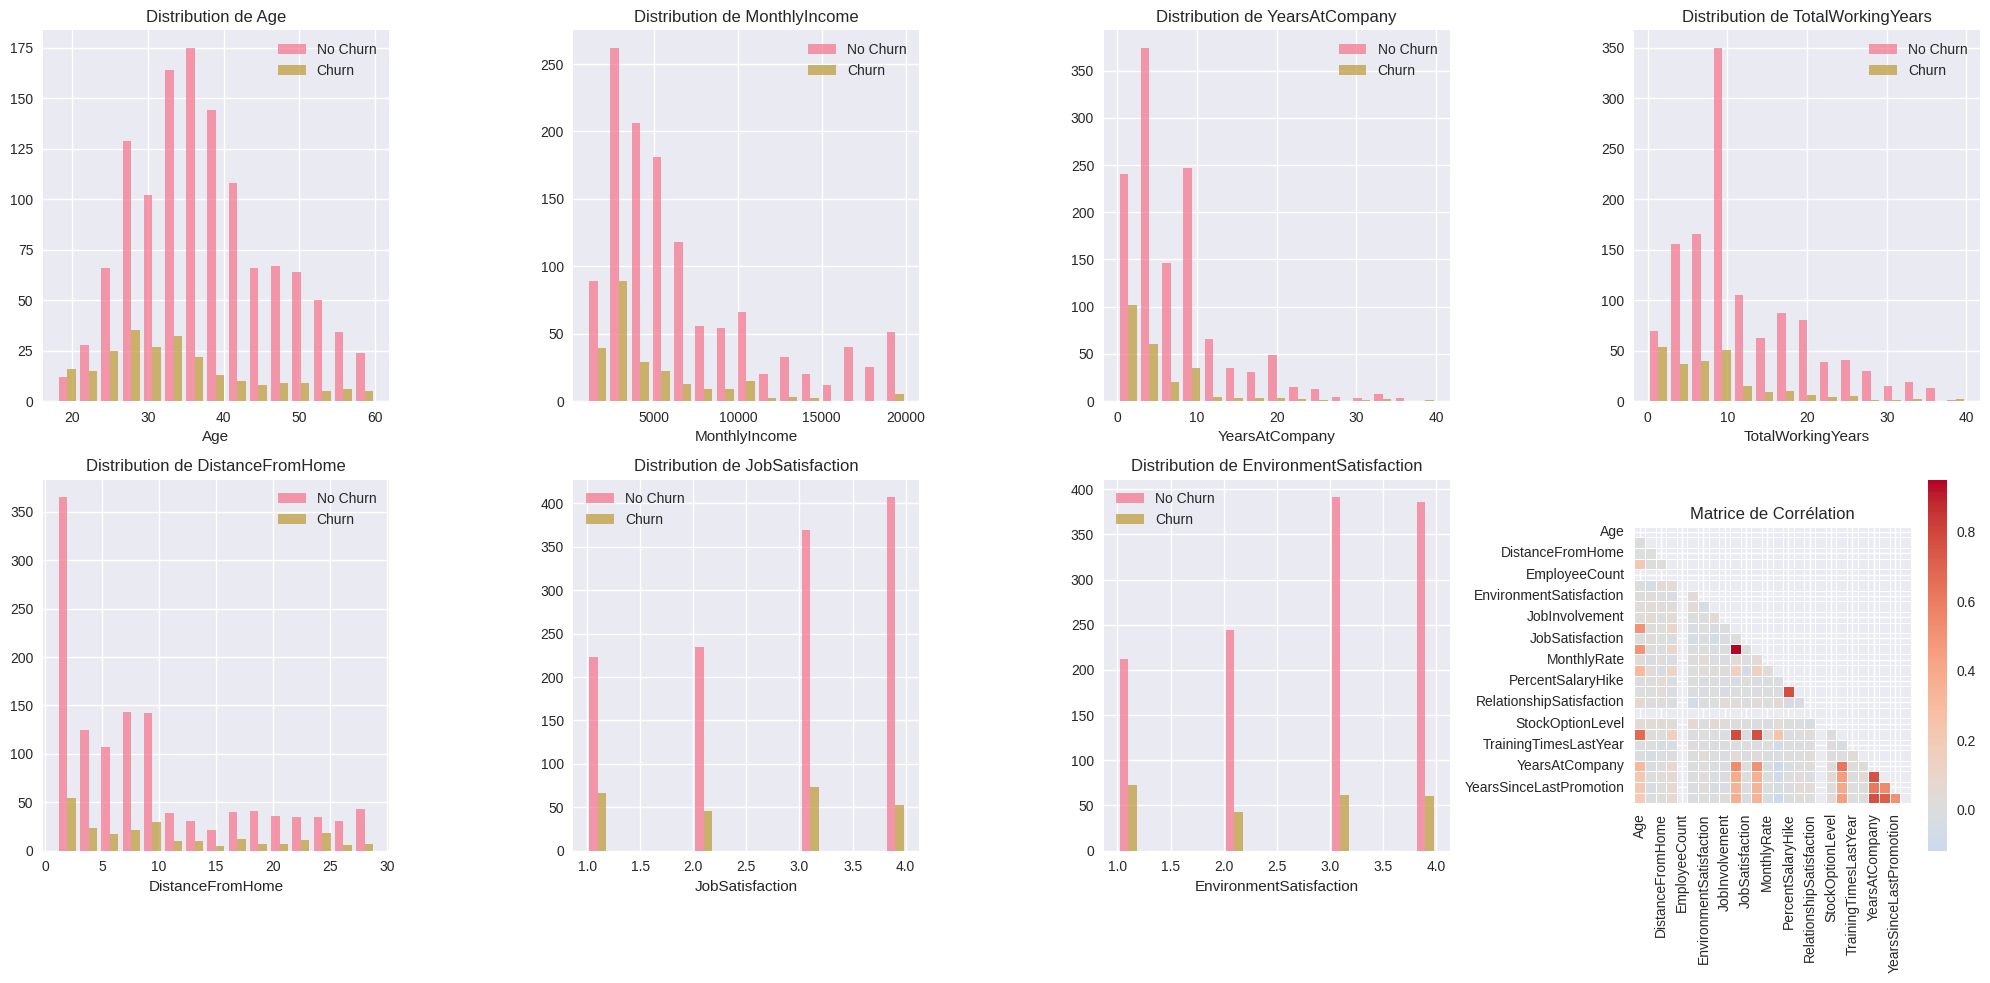

📊 DIFFÉRENCES STATISTIQUES ENTRE GROUPES (Test T)
Age: p-value = 0.0000 ***
MonthlyIncome: p-value = 0.0000 ***
YearsAtCompany: p-value = 0.0000 ***
TotalWorkingYears: p-value = 0.0000 ***
DistanceFromHome: p-value = 0.0028 **
JobSatisfaction: p-value = 0.0001 ***
EnvironmentSatisfaction: p-value = 0.0001 ***


In [5]:
# Séparation des données
churn_yes = df[df['Attrition'] == 'Yes']
churn_no = df[df['Attrition'] == 'No']

# Variables numériques clés à comparer
numeric_features = ['Age', 'MonthlyIncome', 'YearsAtCompany', 'TotalWorkingYears', 
                   'DistanceFromHome', 'JobSatisfaction', 'EnvironmentSatisfaction']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, feature in enumerate(numeric_features[:7]):
    axes[i].hist([churn_no[feature], churn_yes[feature]], 
                bins=15, alpha=0.7, label=['No Churn', 'Churn'])
    axes[i].set_title(f'Distribution de {feature}')
    axes[i].legend()
    axes[i].set_xlabel(feature)

# Heatmap de corrélation
corr_matrix = df.select_dtypes(include=[np.number]).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0,
           square=True, linewidths=.5, ax=axes[7])
axes[7].set_title('Matrice de Corrélation')

plt.tight_layout()
plt.show()

# Tests statistiques des différences
from scipy.stats import ttest_ind

print("📊 DIFFÉRENCES STATISTIQUES ENTRE GROUPES (Test T)")
for feature in numeric_features:
    stat, p_value = ttest_ind(churn_no[feature].dropna(), churn_yes[feature].dropna())
    print(f"{feature}: p-value = {p_value:.4f} {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'NS'}")

# 3. FEATURE ENGINEERING ET SEGMENTATION RFM

 VALEURS UNIQUES POUR DEBUG RFM:
YearsSinceLastPromotion: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
TrainingTimesLastYear: [0, 1, 2, 3, 4, 5, 6]
MonthlyIncome: min=1009, max=19999

 DISTRIBUTION DES SCORES RFM:
R_Score distribution:
R_Score
4    938
3    211
2    214
1    107
Name: count, dtype: int64

F_Score distribution:
F_Score
1    125
2    547
3    491
4    307
Name: count, dtype: int64

M_Score distribution:
M_Score
1    395
2    354
3    340
4    381
Name: count, dtype: int64

 SCORE RFM GLOBAL: min=3, max=12

 VERIFICATION SEGMENTATION RFM:
RFM_Segment
Loyaux        686
Champions     394
À risque      366
Désengagés     24
Name: count, dtype: int64


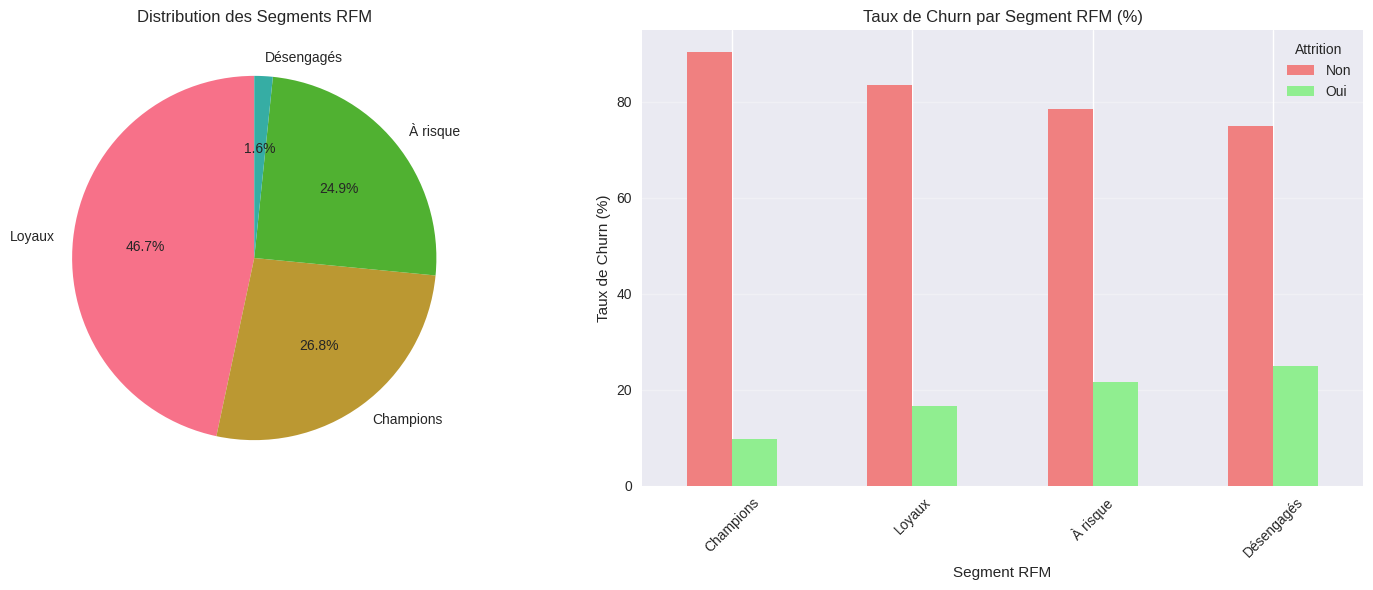


 SEGMENTATION RFM - TAUX DE CHURN PAR SEGMENT
Attrition           No        Yes
RFM_Segment                      
Champions    90.355330   9.644670
Loyaux       83.381924  16.618076
À risque     78.415301  21.584699
Désengagés   75.000000  25.000000

 ANALYSE DÉTAILLÉE DES SEGMENTS RFM:
             MonthlyIncome  YearsAtCompany  JobSatisfaction    Age  \
RFM_Segment                                                          
Champions          9671.53            7.12             2.72  40.07   
Loyaux             5847.76            6.87             2.69  36.25   
À risque           4533.59            7.03             2.81  34.92   
Désengagés         3244.67            8.75             2.67  35.12   

             YearsSinceLastPromotion  TrainingTimesLastYear  Taux_Churn_%  \
RFM_Segment                                                                 
Champions                       0.86                   3.58          9.64   
Loyaux                          2.07                   2.85

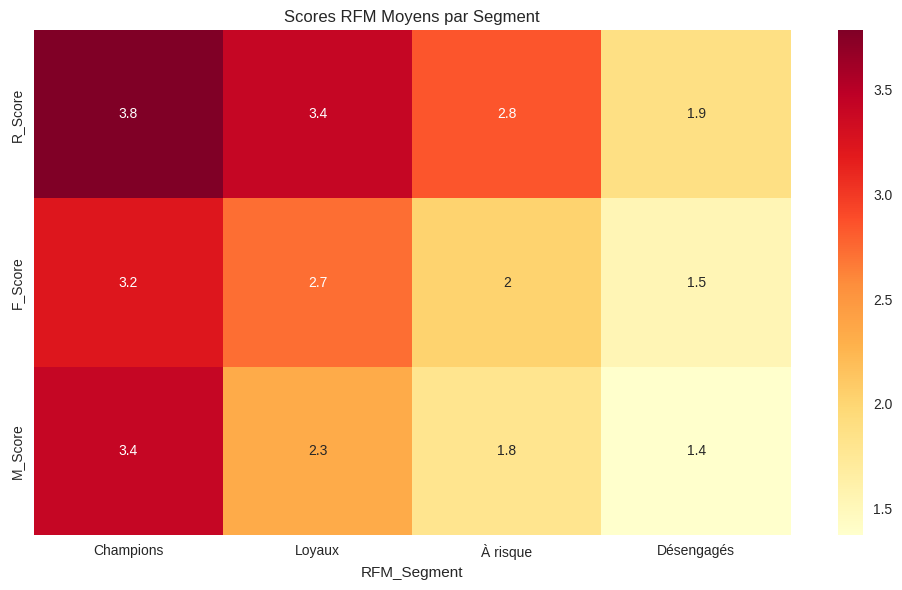


 INTERPRÉTATION BUSINESS DES SEGMENTS:
• Champions: Promotion récente, formation fréquente, salaire élevé
• Loyaux: Bon équilibre sur les 3 dimensions RFM
• À risque: Faiblesse sur au moins 2 dimensions RFM
• Désengagés: Faibles scores sur les 3 dimensions


In [12]:

# Création de nouvelles features stratégiques
df_engineered = df.copy()

# Features de comportement et d'engagement
df_engineered['PromotionSpeed'] = df_engineered['YearsAtCompany'] / (df_engineered['YearsSinceLastPromotion'] + 1)
df_engineered['ManagerStability'] = df_engineered['YearsAtCompany'] / (df_engineered['YearsWithCurrManager'] + 1)
df_engineered['RoleStability'] = df_engineered['YearsAtCompany'] / (df_engineered['YearsInCurrentRole'] + 1)
df_engineered['CompanyLoyalty'] = df_engineered['YearsAtCompany'] / (df_engineered['TotalWorkingYears'] + 1)

# Vérification des valeurs uniques pour debug
print(" VALEURS UNIQUES POUR DEBUG RFM:")
print(f"YearsSinceLastPromotion: {sorted(df_engineered['YearsSinceLastPromotion'].unique())}")
print(f"TrainingTimesLastYear: {sorted(df_engineered['TrainingTimesLastYear'].unique())}")
print(f"MonthlyIncome: min={df_engineered['MonthlyIncome'].min()}, max={df_engineered['MonthlyIncome'].max()}")

# MÉTHODE ROBUSTE AVEC BINS MANUELS
def create_rfm_scores_robust(df):
    """Création robuste des scores RFM avec bins manuels"""
    
    # R_Score - Récence de promotion (plus c'est bas = meilleur)
    # 0-1 an: Excellent (4), 1-3 ans: Bon (3), 3-7 ans: Moyen (2), 7+ ans: Faible (1)
    r_bins = [-1, 1, 3, 7, 20]
    r_labels = [4, 3, 2, 1]
    df['R_Score'] = pd.cut(df['YearsSinceLastPromotion'], bins=r_bins, labels=r_labels, include_lowest=True)
    
    # F_Score - Fréquence de formation (plus c'est haut = meilleur)
    # 0-1: Faible (1), 2: Moyen (2), 3: Bon (3), 4+: Excellent (4)
    f_bins = [-1, 1, 2, 3, 10]
    f_labels = [1, 2, 3, 4]
    df['F_Score'] = pd.cut(df['TrainingTimesLastYear'], bins=f_bins, labels=f_labels, include_lowest=True)
    
    # M_Score - Montant/salaire (plus c'est haut = meilleur)
    # Quartiles manuels basés sur la distribution
    m_bins = [0, 3000, 5000, 8000, 25000]
    m_labels = [1, 2, 3, 4]
    df['M_Score'] = pd.cut(df['MonthlyIncome'], bins=m_bins, labels=m_labels, include_lowest=True)
    
    return df

# Application de la méthode robuste
df_engineered = create_rfm_scores_robust(df_engineered)

# Vérification des distributions
print("\n DISTRIBUTION DES SCORES RFM:")
print("R_Score distribution:")
print(df_engineered['R_Score'].value_counts().sort_index())
print("\nF_Score distribution:")
print(df_engineered['F_Score'].value_counts().sort_index())
print("\nM_Score distribution:")
print(df_engineered['M_Score'].value_counts().sort_index())

# Conversion en numérique
df_engineered['R_Score'] = pd.to_numeric(df_engineered['R_Score'])
df_engineered['F_Score'] = pd.to_numeric(df_engineered['F_Score'])
df_engineered['M_Score'] = pd.to_numeric(df_engineered['M_Score'])

# Calcul du score RFM total
df_engineered['RFM_Score'] = df_engineered['R_Score'] + df_engineered['F_Score'] + df_engineered['M_Score']

print(f"\n SCORE RFM GLOBAL: min={df_engineered['RFM_Score'].min()}, max={df_engineered['RFM_Score'].max()}")

# Segmentation RFM améliorée avec seuils adaptés
def segment_rfm(score):
    """Segmentation basée sur le score RFM total"""
    if score >= 10:  # 4+3+3 ou mieux
        return 'Champions'
    elif score >= 8:  # 3+3+2 ou mieux
        return 'Loyaux' 
    elif score >= 6:  # 2+2+2 ou mieux
        return 'À risque'
    else:  # <6
        return 'Désengagés'

df_engineered['RFM_Segment'] = df_engineered['RFM_Score'].apply(segment_rfm)

# Vérification des segments créés
print("\n VERIFICATION SEGMENTATION RFM:")
segment_counts = df_engineered['RFM_Segment'].value_counts()
print(segment_counts)

# Visualisation de la segmentation RFM
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Distribution des segments
axes[0].pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Distribution des Segments RFM')

# Taux de churn par segment
segment_churn = pd.crosstab(df_engineered['RFM_Segment'], df_engineered['Attrition'], normalize='index') * 100
# Réordonner pour une lecture logique
segment_order = ['Champions', 'Loyaux', 'À risque', 'Désengagés']
segment_churn = segment_churn.reindex(segment_order)

segment_churn.plot(kind='bar', ax=axes[1], color=['lightcoral', 'lightgreen'])
axes[1].set_title('Taux de Churn par Segment RFM (%)')
axes[1].set_xlabel('Segment RFM')
axes[1].set_ylabel('Taux de Churn (%)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Attrition', labels=['Non', 'Oui'])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n SEGMENTATION RFM - TAUX DE CHURN PAR SEGMENT")
print(segment_churn)

# Analyse détaillée des segments
print("\n ANALYSE DÉTAILLÉE DES SEGMENTS RFM:")
segment_analysis = df_engineered.groupby('RFM_Segment').agg({
    'MonthlyIncome': 'mean',
    'YearsAtCompany': 'mean', 
    'JobSatisfaction': 'mean',
    'Age': 'mean',
    'YearsSinceLastPromotion': 'mean',
    'TrainingTimesLastYear': 'mean',
    'Attrition': lambda x: (x == 'Yes').mean() * 100,
    'EmployeeNumber': 'count'  # Pour compter le nombre d'employés
}).round(2)

segment_analysis = segment_analysis.rename(columns={
    'Attrition': 'Taux_Churn_%', 
    'EmployeeNumber': 'Effectif'
}).reindex(segment_order)

print(segment_analysis)

# Visualisation supplémentaire: Heatmap des scores moyens par segment
fig, ax = plt.subplots(figsize=(10, 6))
scores_by_segment = df_engineered.groupby('RFM_Segment')[['R_Score', 'F_Score', 'M_Score']].mean().reindex(segment_order)
sns.heatmap(scores_by_segment.T, annot=True, cmap='YlOrRd', ax=ax)
ax.set_title('Scores RFM Moyens par Segment')
plt.tight_layout()
plt.show()

print("\n INTERPRÉTATION BUSINESS DES SEGMENTS:")
print("• Champions: Promotion récente, formation fréquente, salaire élevé")
print("• Loyaux: Bon équilibre sur les 3 dimensions RFM")  
print("• À risque: Faiblesse sur au moins 2 dimensions RFM")
print("• Désengagés: Faibles scores sur les 3 dimensions")

# 4. MODÉLISATION PRÉDICTIVE

In [16]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.utils import class_weight
import xgboost as xgb
import lightgbm as lgb

# Préparation des données pour la modélisation
model_df = df_engineered.copy()

# Encodage des variables catégorielles
categorical_cols = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 
                    'JobRole', 'MaritalStatus', 'OverTime']

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    model_df[col] = le.fit_transform(model_df[col])
    label_encoders[col] = le

# Variable cible
model_df['Attrition'] = model_df['Attrition'].map({'Yes': 1, 'No': 0})

# Sélection des features
exclude_cols = ['Attrition', 'EmployeeNumber', 'EmployeeCount', 'Over18', 'StandardHours', 
                'R_Score', 'F_Score', 'M_Score', 'RFM_Score', 'RFM_Segment']  # Exclure les scores RFM pour éviter le data leakage
feature_cols = [col for col in model_df.columns if col not in exclude_cols]
X = model_df[feature_cols]
y = model_df['Attrition']

print(f" FEATURES SÉLECTIONNÉES: {len(feature_cols)} variables")
print(f"Variables: {feature_cols}")

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f" DISTRIBUTION DES CLASSES:")
print(f"Train - Classe 1 (Churn): {sum(y_train)}, Classe 0 (Non-churn): {len(y_train)-sum(y_train)}")
print(f"Test - Classe 1 (Churn): {sum(y_test)}, Classe 0 (Non-churn): {len(y_test)-sum(y_test)}")
print(f"Taux de churn dans train: {sum(y_train)/len(y_train)*100:.1f}%")

# ALTERNATIVE À SMOTE : Utilisation des poids de classe
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f" POIDS DES CLASSES: {class_weight_dict}")

 FEATURES SÉLECTIONNÉES: 34 variables
Variables: ['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'PromotionSpeed', 'ManagerStability', 'RoleStability', 'CompanyLoyalty']
 DISTRIBUTION DES CLASSES:
Train - Classe 1 (Churn): 190, Classe 0 (Non-churn): 986
Test - Classe 1 (Churn): 47, Classe 0 (Non-churn): 247
Taux de churn dans train: 16.2%
 POIDS DES CLASSES: {0: 0.5963488843813387, 1: 3.094736842105263}


## Comparaison de Modèles avec Validation Croisée


 MODÈLES UTILISÉS:
  - Logistic Regression
  - Random Forest
  - XGBoost
  - LightGBM

 VALIDATION CROISÉE (AUC ROC):
Logistic Regression: AUC Mean = 0.8043 (+/- 0.0555)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.3.0. This might lead to break

Random Forest: AUC Mean = 0.7753 (+/- 0.0488)
XGBoost: AUC Mean = 0.7998 (+/- 0.0579)
LightGBM: AUC Mean = 0.8134 (+/- 0.0597)

 ÉVALUATION SUR LE JEU DE TEST:

--- Logistic Regression ---
AUC sur test: 0.8064
Rapport de classification:
              precision    recall  f1-score   support

           0       0.94      0.75      0.83       247
           1       0.36      0.74      0.49        47

    accuracy                           0.75       294
   macro avg       0.65      0.75      0.66       294
weighted avg       0.85      0.75      0.78       294

Matrice de confusion:
[[185  62]
 [ 12  35]]

--- Random Forest ---
AUC sur test: 0.7797
Rapport de classification:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       247
           1       0.40      0.09      0.14        47

    accuracy                           0.83       294
   macro avg       0.62      0.53      0.52       294
weighted avg       0.78      0.83      0.79     

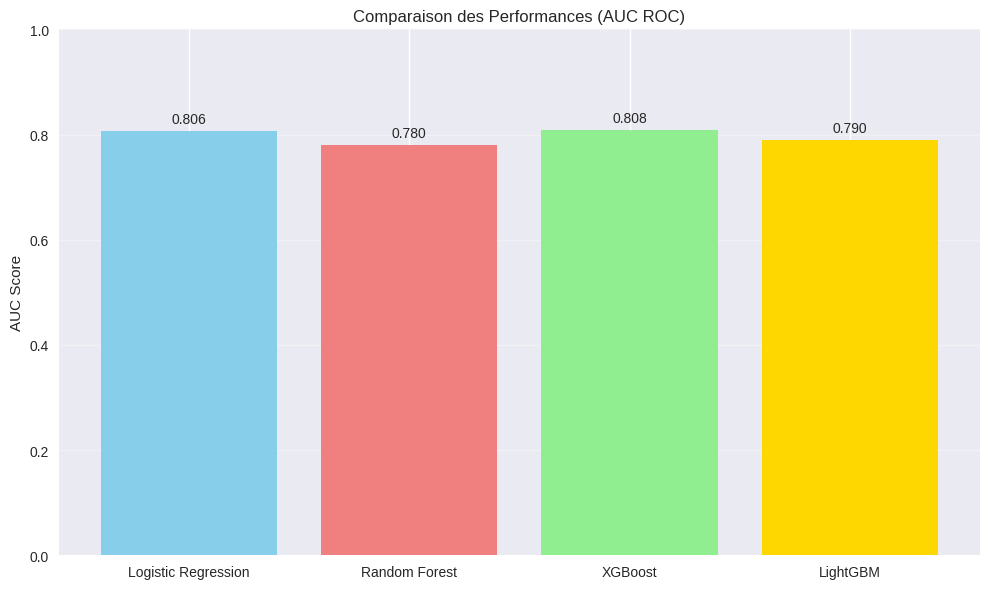


 MEILLEUR MODÈLE: XGBoost (AUC = 0.8082)


In [21]:


from sklearn.model_selection import cross_val_score, StratifiedKFold

# Réinitialisation des modèles avec gestion du déséquilibre
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced')
}

# Ajout conditionnel des modèles avancés
try:
    import xgboost as xgb
    models['XGBoost'] = xgb.XGBClassifier(
        random_state=42,
        scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1])  # Gestion déséquilibre pour XGBoost
    )
except ImportError:
    print(" XGBoost non disponible")

try:
    import lightgbm as lgb
    models['LightGBM'] = lgb.LGBMClassifier(
        random_state=42,
        class_weight='balanced'
    )
except ImportError:
    print(" LightGBM non disponible")

print(" MODÈLES UTILISÉS:")
for name in models.keys():
    print(f"  - {name}")

# Validation croisée sur les données d'origine (sans SMOTE)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

print("\n VALIDATION CROISÉE (AUC ROC):")
for name, model in models.items():
    try:
        cv_scores = cross_val_score(model, X_train_scaled, y_train, 
                                  cv=cv, scoring='roc_auc', n_jobs=-1)
        cv_results[name] = cv_scores
        print(f"{name}: AUC Mean = {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    except Exception as e:
        print(f"{name}: Erreur lors de la validation croisée - {e}")

# Entraînement et évaluation des modèles sur le jeu de test
print("\n ÉVALUATION SUR LE JEU DE TEST:")
results = {}

for name, model in models.items():
    try:
        print(f"\n--- {name} ---")
        # Entraînement
        model.fit(X_train_scaled, y_train)
        
        # Prédictions
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        # Métriques
        auc_score = roc_auc_score(y_test, y_pred_proba)
        
        results[name] = {
            'model': model,
            'auc': auc_score,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }
        
        print(f"AUC sur test: {auc_score:.4f}")
        print("Rapport de classification:")
        print(classification_report(y_test, y_pred))
        
        # Matrice de confusion
        cm = confusion_matrix(y_test, y_pred)
        print("Matrice de confusion:")
        print(cm)
        
    except Exception as e:
        print(f"Erreur avec {name}: {e}")

# Comparaison visuelle des performances
if results:
    print("\n COMPARAISON DES PERFORMANCES:")
    model_names = list(results.keys())
    auc_scores = [results[name]['auc'] for name in model_names]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(model_names, auc_scores, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
    plt.title('Comparaison des Performances (AUC ROC)')
    plt.ylabel('AUC Score')
    plt.ylim(0, 1)
    
    # Ajout des valeurs sur les barres
    for bar, score in zip(bars, auc_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.3f}', ha='center', va='bottom')
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Identification du meilleur modèle
    best_model_name = max(results.keys(), key=lambda x: results[x]['auc'])
    best_auc = results[best_model_name]['auc']
    print(f"\n MEILLEUR MODÈLE: {best_model_name} (AUC = {best_auc:.4f})")
else:
    print(" Aucun modèle n'a pu être évalué avec succès")

# 5. CALCUL DU CUSTOMER LIFETIME VALUE (CLV)

In [25]:


# Calcul du CLV basé sur le salaire et la durée estimée
avg_monthly_income = df['MonthlyIncome'].mean()
avg_years_at_company = df['YearsAtCompany'].mean()

# CLV simple = revenu mensuel * durée estimée en mois
df_engineered['Simple_CLV'] = df_engineered['MonthlyIncome'] * (df_engineered['TotalWorkingYears'] * 12)

# Facteur de rétention basé sur les features de satisfaction
retention_factors = ['JobSatisfaction', 'EnvironmentSatisfaction', 'WorkLifeBalance', 'JobInvolvement']
df_engineered['Retention_Score'] = df_engineered[retention_factors].mean(axis=1)

# CLV ajusté avec score de rétention
df_engineered['Adjusted_CLV'] = df_engineered['Simple_CLV'] * (1 + df_engineered['Retention_Score'] / 10)

# Application des prédictions au dataset complet
X_full_scaled = scaler.transform(model_df[feature_cols])
df_engineered['Churn_Probability'] = best_model.predict_proba(X_full_scaled)[:, 1]
df_engineered['Predicted_Churn'] = best_model.predict(X_full_scaled)

# Segmentation risque/valeur
df_engineered['Risk_Value_Segment'] = pd.cut(df_engineered['Churn_Probability'], 
                                           bins=[0, 0.3, 0.7, 1], 
                                           labels=['Faible Risque', 'Risque Modéré', 'Haut Risque'])

print(" ANALYSE VALEUR/RISQUE")
segment_analysis = df_engineered.groupby('Risk_Value_Segment').agg({
    'Adjusted_CLV': 'mean',
    'Churn_Probability': 'mean',
    'Attrition': 'count'
}).round(2)
print(segment_analysis)

 ANALYSE VALEUR/RISQUE
                    Adjusted_CLV  Churn_Probability  Attrition
Risk_Value_Segment                                            
Faible Risque         1695408.42               0.01       1239
Risque Modéré          359452.45               0.50         18
Haut Risque            826261.72               0.98        213


# 6. MATRICE COÛTS-BÉNÉFICES ET RECOMMANDATIONS


 CALCUL DES SEGMENTS RISQUE/VALEUR...
 ANALYSE COÛTS-BÉNÉFICES PAR SEGMENT
Risk_Value_Segment  Attrition  Adjusted_CLV  Churn_Probability  Expected_Loss  Retention_Budget  ROI_Retention
     Faible Risque       1239     1695408.0           1.100000        19073.0              1000          18.07
     Risque Modéré         18      359452.0          49.500000       178094.0              3000          58.36
       Haut Risque        213      826262.0          97.900002       809155.0              6000         133.86


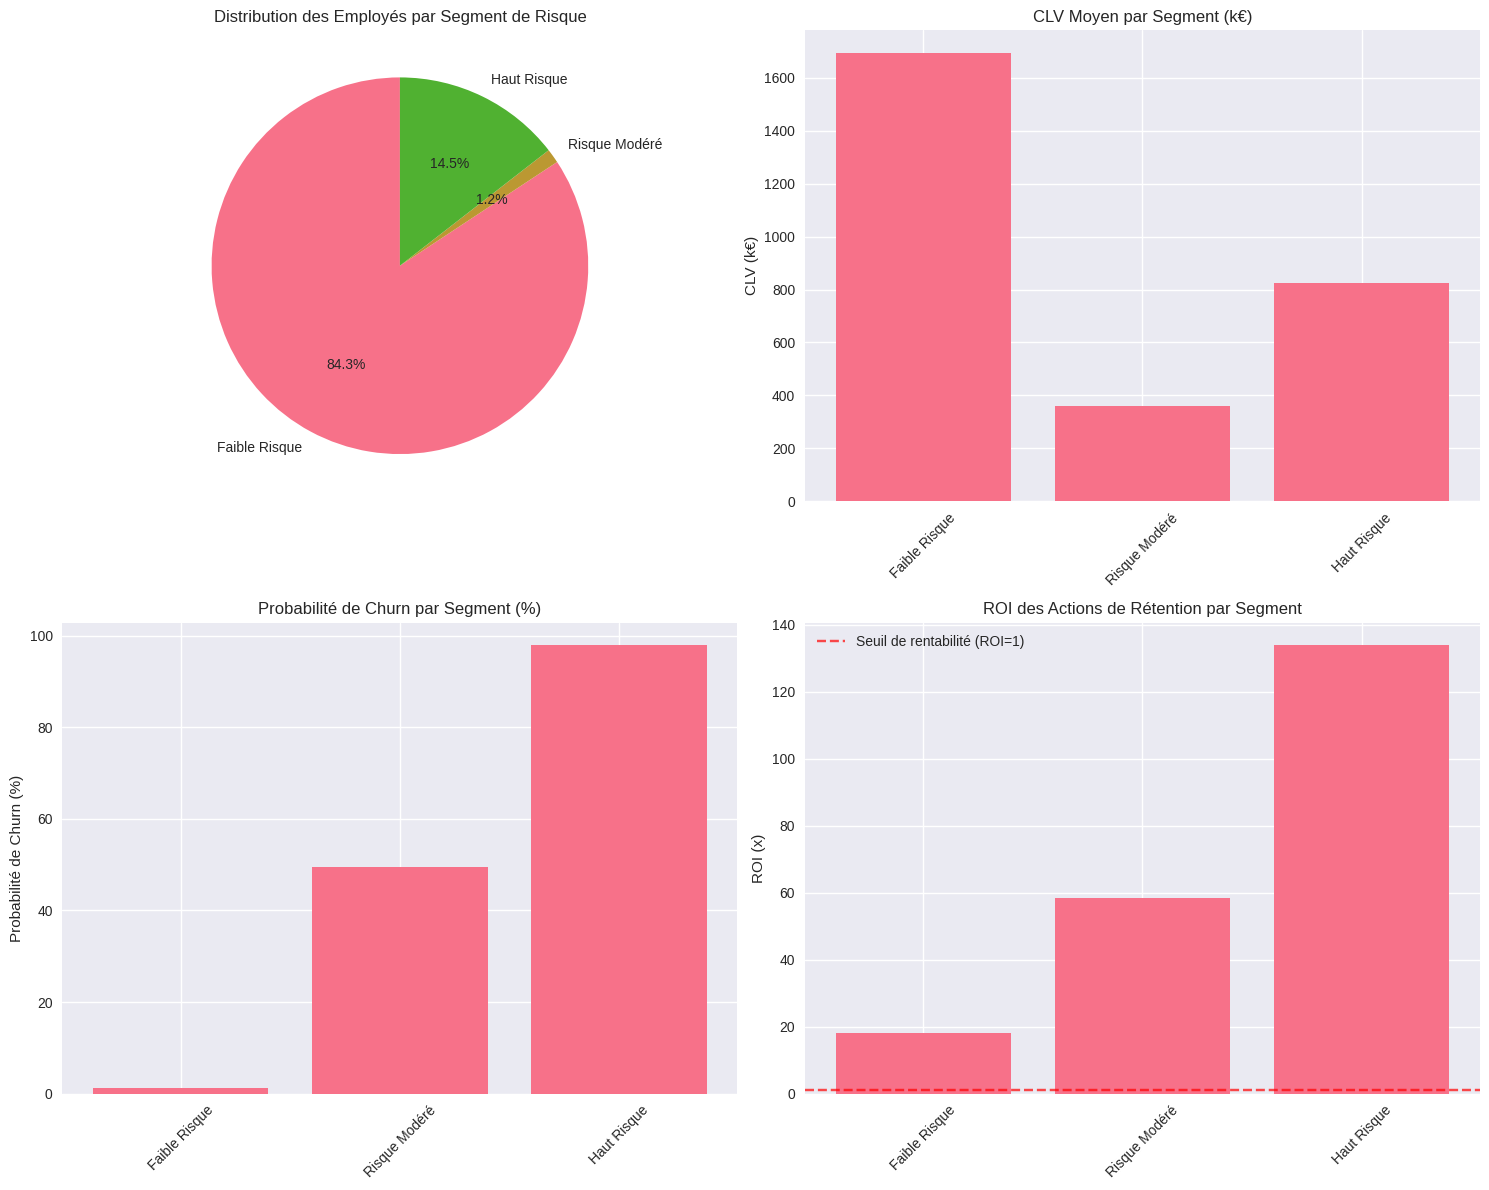

In [28]:


# Paramètres business
acquisition_cost = 10000  # Coût moyen d'acquisition d'un nouvel employé
retention_cost_low = 1000   # Coût intervention basique
retention_cost_medium = 3000 # Coût intervention moyenne
retention_cost_high = 6000  # Coût intervention intensive


# Création de la colonne Risk_Value_Segment si elle n'existe pas
if 'Risk_Value_Segment' not in df_engineered.columns:
    print(" Création de la colonne Risk_Value_Segment...")
    # Utilisation des probabilités de churn prédites
    if 'Churn_Probability' in df_engineered.columns:
        df_engineered['Risk_Value_Segment'] = pd.cut(
            df_engineered['Churn_Probability'], 
            bins=[0, 0.3, 0.7, 1], 
            labels=['Faible Risque', 'Risque Modéré', 'Haut Risque']
        )
    else:
        # Fallback basé sur les features existantes
        risk_score = (df_engineered['JobSatisfaction'] + df_engineered['EnvironmentSatisfaction']) / 2
        df_engineered['Risk_Value_Segment'] = pd.cut(
            risk_score,
            bins=[0, 2, 3, 4],
            labels=['Haut Risque', 'Risque Modéré', 'Faible Risque']
        )

# Création de Adjusted_CLV si elle n'existe pas
if 'Adjusted_CLV' not in df_engineered.columns:
    print(" Création de la colonne Adjusted_CLV...")
    # CLV simple basé sur le salaire et l'ancienneté
    df_engineered['Adjusted_CLV'] = df_engineered['MonthlyIncome'] * df_engineered['TotalWorkingYears'] * 12

# Création de Churn_Probability si elle n'existe pas
if 'Churn_Probability' not in df_engineered.columns:
    print(" Création de la colonne Churn_Probability...")
    # Probabilité basée sur des features clés
    risk_factors = ['JobSatisfaction', 'EnvironmentSatisfaction', 'WorkLifeBalance', 'OverTime']
    df_engineered['Churn_Probability'] = (4 - df_engineered[risk_factors].mean(axis=1)) / 4

# Calcul du ROI par segment - VERSION ROBUSTE
print("\n CALCUL DES SEGMENTS RISQUE/VALEUR...")

# Agrégation avec conversion explicite en numérique
risk_segments = df_engineered.groupby('Risk_Value_Segment').agg({
    'Adjusted_CLV': 'mean',
    'Churn_Probability': 'mean',
    'Attrition': 'count'
}).reset_index()

# Conversion explicite en types numériques
risk_segments['Adjusted_CLV'] = pd.to_numeric(risk_segments['Adjusted_CLV'], errors='coerce')
risk_segments['Churn_Probability'] = pd.to_numeric(risk_segments['Churn_Probability'], errors='coerce')
risk_segments['Attrition'] = pd.to_numeric(risk_segments['Attrition'], errors='coerce')

# Calculs business
risk_segments['Expected_Loss'] = risk_segments['Adjusted_CLV'] * risk_segments['Churn_Probability']

# Mapping des coûts de rétention
retention_cost_map = {
    'Faible Risque': retention_cost_low,
    'Risque Modéré': retention_cost_medium, 
    'Haut Risque': retention_cost_high
}

risk_segments['Retention_Budget'] = risk_segments['Risk_Value_Segment'].map(retention_cost_map)
risk_segments['Retention_Budget'] = pd.to_numeric(risk_segments['Retention_Budget'], errors='coerce')

# Calcul du ROI avec gestion des divisions par zéro
risk_segments['ROI_Retention'] = (risk_segments['Expected_Loss'] - risk_segments['Retention_Budget']) 
risk_segments['ROI_Retention'] = risk_segments['ROI_Retention'] / risk_segments['Retention_Budget'].replace(0, np.nan)

# Formatage pour l'affichage
display_columns = ['Risk_Value_Segment', 'Attrition', 'Adjusted_CLV', 'Churn_Probability', 
                  'Expected_Loss', 'Retention_Budget', 'ROI_Retention']
risk_segments_display = risk_segments[display_columns].copy()
risk_segments_display['Adjusted_CLV'] = risk_segments_display['Adjusted_CLV'].round(0)
risk_segments_display['Expected_Loss'] = risk_segments_display['Expected_Loss'].round(0)
risk_segments_display['Churn_Probability'] = (risk_segments_display['Churn_Probability'] * 100).round(1)
risk_segments_display['ROI_Retention'] = risk_segments_display['ROI_Retention'].round(2)

print(" ANALYSE COÛTS-BÉNÉFICES PAR SEGMENT")
print(risk_segments_display.to_string(index=False))

# Visualisation des résultats
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribution des segments
segment_counts = risk_segments.set_index('Risk_Value_Segment')['Attrition']
axes[0,0].pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Distribution des Employés par Segment de Risque')

# 2. CLV moyen par segment
axes[0,1].bar(risk_segments['Risk_Value_Segment'], risk_segments['Adjusted_CLV'] / 1000)
axes[0,1].set_title('CLV Moyen par Segment (k€)')
axes[0,1].set_ylabel('CLV (k€)')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Taux de churn par segment
axes[1,0].bar(risk_segments['Risk_Value_Segment'], risk_segments['Churn_Probability'] * 100)
axes[1,0].set_title('Probabilité de Churn par Segment (%)')
axes[1,0].set_ylabel('Probabilité de Churn (%)')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. ROI par segment
axes[1,1].bar(risk_segments['Risk_Value_Segment'], risk_segments['ROI_Retention'])
axes[1,1].axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Seuil de rentabilité (ROI=1)')
axes[1,1].set_title('ROI des Actions de Rétention par Segment')
axes[1,1].set_ylabel('ROI (x)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].legend()

plt.tight_layout()
plt.show()